This script is for calculating the Dispersive surface energy ($\gamma_{d}^{s}$) of a solid sample from Inverse Gas Chromatography measurements, specifically those done on the SEA (Surface energy analyser).  Measured parameters are imported from a csv file and the dispersive surface energy profile (including error and $R^{2}$ value of the fit) is shown and results are output to a different csv file.

In [1]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats,constants
from __future__ import division

# Input data is sorted to be usable

In [2]:
# reads the experimental data file. note: remove other exp details
# Change nrows and skiprows depending on amount of injections
# skiprows skips the first x rows of csv while nrows reads the first x - 1 rows 
#f = pd.read_csv(raw_input('Copy path to input file here \nmake sure to insert extra "\\" and remove "" \n'),skiprows=8,nrows=60,
#     encoding='utf-16', delimiter='\t')
f = pd.read_csv("C:\\Users\\tcd\\Google Drive\\NiCoH2\\test.csv",skiprows=8,nrows=70,
                encoding='utf-16', delimiter='\t')

In [3]:
f.head()

,n/nm,Solvent Name,Unit,En. (Stz Max),En. (Stz Com),En. (Pol Max),En. (Pol Com),Interpolated Retention Volume (Max),Interpolated Retention Volume (Com),Column Temperature [Kelvin]
0,0.02,NONANE,dG (kJ/Mol),NaN,NaN,NaN,NaN,557.549962,3078.691325,343.150526
1,0.02,OCTANE,dG (kJ/Mol),NaN,NaN,NaN,NaN,197.166736,1176.255359,343.150067
2,0.02,HEPTANE,dG (kJ/Mol),NaN,NaN,NaN,NaN,62.867565,232.659090,343.151910
3,0.02,HEXANE,dG (kJ/Mol),NaN,NaN,NaN,NaN,20.590613,69.602423,343.156519
4,0.02,DICHLOROMETHANE,dG (kJ/Mol),6.89429,7.233072,7.25741,7.692245,10.600887,23.526713,343.155256


In [4]:
# Removes  columns that have all null values
df = f.dropna(axis =1, how='all')

In [5]:
# Get rid of columns unrelated to dispersive solvents
df.drop(df.columns[2:7],axis=1,inplace=True)

In [6]:
# Renames columns to make life easier
df.rename(columns = {'n/nm' : 'n_nm',
                     'Solvent Name' : 'solvent',
                     'Interpolated Retention Volume (Max)' : 'max',
                     'Interpolated Retention Volume (Com)' : 'com',
                     'Column Temperature [Kelvin]': 'temperature (K)'},inplace=True)

In [7]:
# Gets rid of Specifc solvents
# NOTE: IF MORE OR LESS OR DIFFERENT SOLVENTS USED CHANGE THIS LINE ACCORDINGLY
df = df[(df.solvent != 'DICHLOROMETHANE') & (df.solvent != 'ETHYL ACETATE') & (df.solvent !='1-PROPANOL')]

In [8]:
p_d_map = {'NONANE': 43.8212,
               'OCTANE' : 39.164,
               'HEPTANE' : 34.574,
               'HEXANE' : 29.89}


In [9]:
df['p_d'] = df['solvent'].map(p_d_map)

# Calculations

Gibbs Free Energy of adsorption is calculated by $\Delta G=RT\ln V_{n}$ ($\frac{kJol}{Mol})$ where $V_{n}$ is the column called 'com'

In [10]:
# Import real gas const
# RTLnVn is the Gibbs free energy of adsorption
R= constants.R
df['RTLnVn'] = R * df['temperature (K)'] * np.log(df['com'])

In [11]:
# Creates coverage list for the data set
cov = df['n_nm'].unique().tolist()
cov

[0.02, 0.03, 0.05, 0.07, 0.09, 0.1, 0.13, 0.15, 0.2, 0.25]

In [12]:
# List where each element corresponds to part of dataframe with coverage value
cov_sep_list = [df.loc[df.n_nm == i] for i in cov]
cov_sep_list

[   n_nm  solvent         max          com  temperature (K)      p_d  \
 0  0.02   NONANE  557.549962  3078.691325       343.150526  43.8212   
 1  0.02   OCTANE  197.166736  1176.255359       343.150067  39.1640   
 2  0.02  HEPTANE   62.867565   232.659090       343.151910  34.5740   
 3  0.02   HEXANE   20.590613    69.602423       343.156519  29.8900   
 
          RTLnVn  
 0  22916.937457  
 1  20171.735509  
 2  15548.308617  
 3  12105.393409  ,
     n_nm  solvent         max          com  temperature (K)      p_d  \
 7   0.03   NONANE  516.553479  2638.739975       343.150526  43.8212   
 8   0.03   OCTANE  175.318611   791.243030       343.150067  39.1640   
 9   0.03  HEPTANE   60.318826   206.115757       343.151910  34.5740   
 10  0.03   HEXANE   20.615158    59.780684       343.156519  29.8900   
 
           RTLnVn  
 7   22476.978760  
 8   19040.517805  
 9   15202.691758  
 10  11671.379603  ,
     n_nm  solvent         max          com  temperature (K)      p_d  \
 

C:\Users\tcd\Anaconda2\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


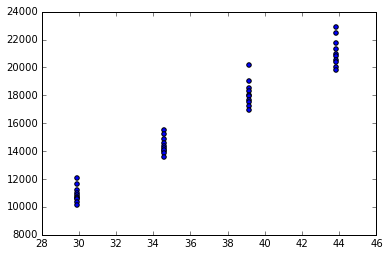

In [13]:
a = [plt.scatter(df['p_d'],df['RTLnVn']) for df in cov_sep_list]

In [14]:
# Linear Regression on Gibbs free energy of adsorption vs carbon number
# result is list of tuples containing slope, standard error of slope, r_value etc in a list of tuples
result = [stats.linregress(df['p_d'],df['RTLnVn']) for df in cov_sep_list]

In [15]:
# Unzips list of tuples to individual tuples
slopes, intercepts,r_values,p_values,std_errs = zip(*result)

In [16]:
# turns tuples to numpy arrays for calculations
slopes = np.array(slopes)
slopes

array([ 798.75074682,  781.56803331,  757.86928036,  746.9433319 ,
        734.8213594 ,  731.70078248,  716.18924968,  707.23750305,
        700.44156359,  697.90308276])

In [17]:
r_values = np.array(r_values)
std_errs = np.array(std_errs)
intercepts = np.array(intercepts)

In [18]:
# Computes R^2 of linear fit
r_sq_arr = r_values ** 2

In [19]:
intercepts

array([-11758.19590649, -11712.50333314, -11353.79045267, -11251.84579566,
       -11058.2144697 , -11036.1525093 , -10697.46612027, -10427.30572092,
       -10449.81350303, -10578.66921261])

In [20]:
M_w_dcm = 16.36
M_w_ethyl = 22.2
M_w_pro = 17.48
M_w_eth = 12.88
M_w_meth = 8.24

In [21]:
disp_comp_dcm = slopes * M_w_dcm + intercepts
disp_comp_ethyl = slopes * M_w_ethyl + intercepts
disp_comp_pro = slopes * M_w_pro + intercepts
disp_comp_eth = slopes * M_w_eth + intercepts
disp_comp_meth = slopes * M_w_meth + intercepts

In [22]:
hydrogen_df = pd.read_csv("C:\\Users\\tcd\\Google Drive\\NiCoH2\\hydrogen_probes.csv",skiprows=8,nrows=20,
                encoding='utf-16', delimiter='\t')
#hydrogen_df = f.dropna(axis =1, how='all')
hydrogen_df.drop(hydrogen_df.columns[2:7],axis=1,inplace=True)
hydrogen_df.rename(columns = {'n/nm' : 'n_nm',
                     'Solvent Name' : 'solvent',
                     'Interpolated Retention Volume (Max)' : 'max',
                     'Interpolated Retention Volume (Com)' : 'com',
                     'Column Temperature [Kelvin]': 'temperature (K)'},inplace=True) 
hydrogen_df['RTLnVn'] = R * hydrogen_df['temperature (K)'] * np.log(hydrogen_df['com'])
hydrogen_df

,n_nm,solvent,max,com,temperature (K),RTLnVn
0,0.02,ETHANOL,100.362352,1365.796489,343.150248,20598.005863
1,0.02,METHANOL,62.664133,2417.851526,343.149880,22227.511596
2,0.03,ETHANOL,78.108370,1821.155237,343.150248,21418.940481
3,0.03,METHANOL,32.591625,500.072118,343.149880,17731.351295
4,0.05,ETHANOL,43.236761,788.205529,343.150248,19029.553965
5,0.05,METHANOL,19.118700,241.190989,343.149880,15650.970856
6,0.07,ETHANOL,33.422293,362.681271,343.150248,16814.871840
7,0.07,METHANOL,14.699636,181.927345,343.149880,14846.446985
8,0.09,ETHANOL,28.647715,253.552011,343.150248,15793.585709
9,0.09,METHANOL,13.716952,152.304197,343.149880,14339.371218


In [23]:
specific_df = pd.read_csv("C:\\Users\\tcd\\Google Drive\\NiCoH2\\test.csv",skiprows=8,nrows=70,
                encoding='utf-16', delimiter='\t')

In [24]:
specific_df = f.dropna(axis =1, how='all')

In [25]:
specific_df.drop(specific_df.columns[2:7],axis=1,inplace=True)

In [26]:
specific_df.rename(columns = {'n/nm' : 'n_nm',
                     'Solvent Name' : 'solvent',
                     'Interpolated Retention Volume (Max)' : 'max',
                     'Interpolated Retention Volume (Com)' : 'com',
                     'Column Temperature [Kelvin]': 'temperature (K)'},inplace=True)
specific_df['RTLnVn'] = R * specific_df['temperature (K)'] * np.log(specific_df['com'])
specific_df.tail(8)

,n_nm,solvent,max,com,temperature (K),RTLnVn
62,0.20,1-PROPANOL,59.684283,237.084206,343.151751,15602.057485
63,0.25,NONANE,338.806873,1045.529121,343.150526,19835.629175
64,0.25,OCTANE,126.805794,383.830797,343.150067,16976.569776
65,0.25,HEPTANE,43.098366,118.009409,343.151910,13611.580137
66,0.25,HEXANE,16.839650,35.280956,343.156519,10166.795291
67,0.25,DICHLOROMETHANE,9.405629,14.726561,343.155256,7673.986373
68,0.25,ETHYL ACETATE,19.768204,92.843753,343.151347,12927.247633
69,0.25,1-PROPANOL,59.271042,203.948271,343.151751,15172.522820


In [27]:
df_dcm = specific_df.loc[specific_df['solvent'] == 'DICHLOROMETHANE']
df_ethyl = specific_df.loc[specific_df['solvent'] == 'ETHYL ACETATE']
df_pro = specific_df.loc[specific_df['solvent'] == '1-PROPANOL']
df_ethanol = hydrogen_df.loc[hydrogen_df['solvent'] == 'ETHANOL']
df_methanol = hydrogen_df.loc[hydrogen_df['solvent'] == 'METHANOL']

In [28]:
delta_G_dcm = df_dcm.RTLnVn.values
delta_G_ethyl = df_ethyl.RTLnVn.values
delta_G_pro = df_pro.RTLnVn.values
delta_G_eth = df_ethanol.RTLnVn.values
delta_G_meth = df_methanol.RTLnVn.values

In [29]:
dcm_specific = delta_G_dcm - disp_comp_dcm
ethyl_specific = delta_G_ethyl - disp_comp_ethyl
pro_specific = delta_G_pro - disp_comp_pro
eth_specific = delta_G_eth - disp_comp_eth
meth_specific = delta_G_meth - disp_comp_meth

In [33]:
dcm_specific

array([ 7701.27517821,  7481.39627231,  7381.69481828,  7279.23892712,
        7062.23488274,  7044.02159292,  6809.59685802,  6607.49620735,
        6730.02741961,  6834.96115124])

In [34]:
ethyl_specific

array([ 12013.23278852,  11854.72133296,  11286.75676176,  10876.63257671,
        10453.07640759,  10064.1355022 ,   8943.69295421,   8651.1899332 ,
         8290.60864207,   8012.46840798])

In [35]:
pro_specific

array([ 20195.92090722,  19529.75047214,  17385.13889143,  16685.50768278,
        16083.19426208,  15557.77076657,  14262.90223164,  13989.48729161,
        13808.15245672,  13551.84614605])

In [36]:
eth_specific

array([ 22068.29215055,  23064.84754513,  20621.98808652,  18446.08752052,
        17387.30106946,  16979.14441109,  16361.66875113,  16157.2303655 ,
        14106.14125358,  13586.86358207])

In [37]:
meth_specific

array([ 27404.00134884,  23003.73403331,  20759.91843836,  19943.47972538,
        19342.65768593,  19198.57176814,  18673.8008453 ,  18091.31003694,
        16864.6919159 ,  16205.15674379])

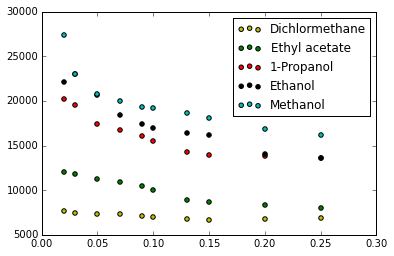

In [60]:
color = ['y','g','r','k','c']
solvent = [dcm_specific,ethyl_specific,pro_specific,eth_specific,meth_specific]
label = ['Dichlormethane','Ethyl acetate', '1-Propanol','Ethanol','Methanol']
for x, k,o in zip(solvent,color,label):
    plt.scatter(cov,x,c=k,label=o)
    plt.legend(loc='best')

In [67]:
specfic_results= DataFrame({
                           'Coverage':cov,
                           'Dichlormethane (J/mol)': dcm_specific,
                           'Ethyl acetate (J/mol)': ethyl_specific,
                           'Propanol (J/mol)' : pro_specific,
                           'Ethanol (J/mol)' : eth_specific,
                           'Methanol (J/mol)' : meth_specific
    })

In [68]:
specfic_results

,Coverage,Dichlormethane (J/mol),Ethanol (J/mol),Ethyl acetate (J/mol),Methanol (J/mol),Propanol (J/mol)
0,0.02,7701.275178,22068.292151,12013.232789,27404.001349,20195.920907
1,0.03,7481.396272,23064.847545,11854.721333,23003.734033,19529.750472
2,0.05,7381.694818,20621.988087,11286.756762,20759.918438,17385.138891
3,0.07,7279.238927,18446.087521,10876.632577,19943.479725,16685.507683
4,0.09,7062.234883,17387.301069,10453.076408,19342.657686,16083.194262
5,0.10,7044.021593,16979.144411,10064.135502,19198.571768,15557.770767
6,0.13,6809.596858,16361.668751,8943.692954,18673.800845,14262.902232
7,0.15,6607.496207,16157.230365,8651.189933,18091.310037,13989.487292
8,0.20,6730.027420,14106.141254,8290.608642,16864.691916,13808.152457
9,0.25,6834.961151,13586.863582,8012.468408,16205.156744,13551.846146


In [69]:
export_specifc_results = specfic_results.to_csv("C:\\Users\\tcd\\Google Drive\\NiCoH2\\specific_results_15May.csv")